In [10]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib notebook

data=[]
TestData=[]
FileNames= glob.glob("*.mat") #
TestFileName=glob.glob("testData/*.mat")

[data.append(loadmat(f,squeeze_me=True, struct_as_record=False)) for f in FileNames]  #loading all the data in the file
[TestData.append(loadmat(f,squeeze_me=True, struct_as_record=False)) for f in TestFileName]

[None, None, None, None, None]

The of actuator signal is equals to length of the cross talk, we will use actuator signal length to zero pad the actuator signal.







In [11]:
frequency=data[0]['setup'].signal_definition.frequency1
# sampling rate of the signal
sampling_rate=data[0]['setup'].sampling_rate
 


Now that we know the sampling frequency and driving frequency of the signal, we will find the amplitue of the cross-talk in the sensor signa by measuring actuator signal length.

In [12]:
crosstalk=[]
frequency=[]
sampling_rate=[]
for signals in data:
    frequency.append(signals['setup'].signal_definition.frequency1)
    sampling_rate.append(signals['setup'].sampling_rate)
    crosstalk.append(5/(signals['setup'].signal_definition.frequency1)* (signals['setup'].sampling_rate))

We calculated the Lambwave frequency, sampling rate and cross-talk for all 5 test. data. we will, now zeropad the cross talk from the sensor signals.

In [13]:
for i in range(5):
    data[i]['s0'][1:int(crosstalk[i])]=0  #training data
    TestData[i]['s0'][1:int(crosstalk[i])]=0  # test data
    
SensorData=list()
ActuatorData=list()

[SensorData.append(signal['s0']) for signal in data ]  # sensor data arranged in list
[ActuatorData.append(signal['a0']) for signal in data]  # Actuator data arrange in list

TestSensorData=list()
TestActuatorData=list()

[TestSensorData.append(signal['s0']) for signal in TestData ]  # Test data  for sensor  arranged in list
[TestActuatorData.append(signal['a0']) for signal in TestData]  # test data for actuator  arrange in list
   
    

[None, None, None, None, None]

We zero-padded the actuator signals to remove the cross-talk

In [14]:
def DynamicTimeWarping(x,y):
    DTW={}
    len1=len(x)
    len2=len(y)
    for i in range(len1):
        DTW[(i,-1)]=float('inf')
    
    for j in range(len2):
        DTW[(-1,j)]=float('inf')
    DTW[(-1,-1)]=0
    for i in range(len1):
        for j in range(len2):
            
            DistTemp= (x[i]-y[j])**2
            DTW[(i,j)]= DistTemp + min(DTW[(i-1,j-1)], DTW[(i-1,j)], DTW[(i,j-1)])
    return(DTW[(len1-1,len2-1)])

We will use Keras to  code sparse encoder to extract feature from LambWaves. 

In [15]:
########################
TotalData=SensorData+TestSensorData
TotalData=np.asarray(TotalData)
#####################################
#####################################
from keras.layers import Input, Dense
from keras.models import Model
#from keras.optimizers import Adam
from keras import regularizers

np.random.seed(7)
SensorData=np.asarray(SensorData) # converting list into array (training data)
TestSensorData=  np.asarray(TestSensorData)
InputSignal=SensorData[0]
actual_signal_len=len(InputSignal)
encoding_dim=100 # This going to be size of our encoded representation
#this returns a tensor
inputs = Input(shape=(actual_signal_len,))
encoded=Dense(encoding_dim,activation='relu',activity_regularizer=regularizers.l1(10e-5))(inputs)
decoded=Dense(actual_signal_len)(encoded)

# this model maps an input to its encoded representation
encoder = Model(input=inputs, output=encoded)

## this model maps an input to its reconstruction
autoencoder= Model(input = inputs, output= decoded)
#we'll configure our model to use a mean squarred error loss, and the Adam optimizer
# we also train autoencoder for 50 epochs
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(TotalData, TotalData, epochs=50, batch_size=1)

#######################
#Encode the images
encoded_signal= encoder.predict(SensorData)
EncodedTestData= encoder.predict(TestSensorData)

Using TensorFlow backend.
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/50
10/10 [==============================] - 1s - loss: 159.8511     
Epoch 2/50
10/10 [==============================] - 0s - loss: 101.7649     
Epoch 3/50
10/10 [==============================] - 0s - loss: 36.3315     
Epoch 4/50
10/10 [==============================] - 0s - loss: 13.3895     
Epoch 5/50
10/10 [==============================] - 0s - loss: 7.5405     
Epoch 6/50
10/10 [==============================] - 0s - loss: 5.7474     
Epoch 7/50
10/10 [==============================] - 0s - loss: 5.6287     
Epoch 8/50
10/10 [==============================] - 0s - loss: 5.0256     
Epoch 9/50
10/10 [==============================] - 0s - loss: 4.2146     
Epoch 10/50
10/10 [==============================] - 0s - loss: 5.4936     
Epoch 11/50
10/10 [==============================] - 0s - loss: 12.0689     
Epoch 12/50
10/10 [==============================] - 0s - loss: 11.6494     
Epoch 13/50
10/10 [==============================] - 0s - loss: 11.2474     
Epoch 14/50


In the above code we iterate over the testdata0 to testdata5 to estimate the Dynamic time warping value all states with respect to the baseline signal. Now a linear relationship between damage size and DTW distance will be used to calibrate the damage size. This will enable us to quantify the size of the damage as well as its detection. We will set a threshold for the damage detection.

<IPython.core.display.Javascript object>


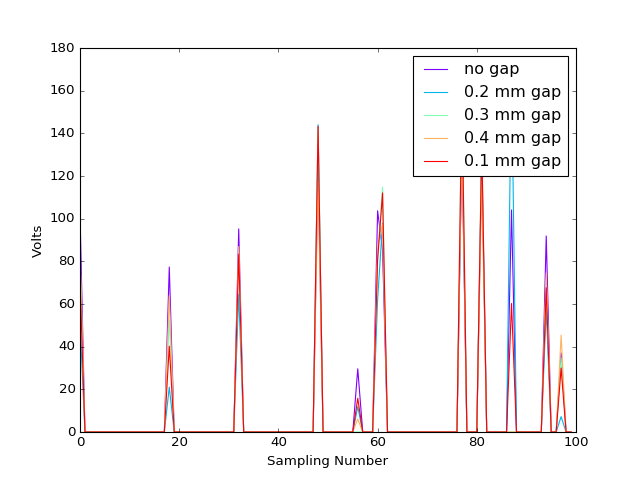

In [17]:
from matplotlib.pyplot import cm
c=cm.rainbow(np.linspace(0,1,5))
labels=['no gap','0.2 mm gap','0.3 mm gap','0.4 mm gap','0.1 mm gap']
#%matplotlib notebook
plt.figure()
for c,signal,l in zip(c,encoded_signal,labels):
    plt.plot(signal,color=c,label=l)
plt.xlabel('Sampling Number')
plt.ylabel('Volts')
plt.legend()


<IPython.core.display.Javascript object>


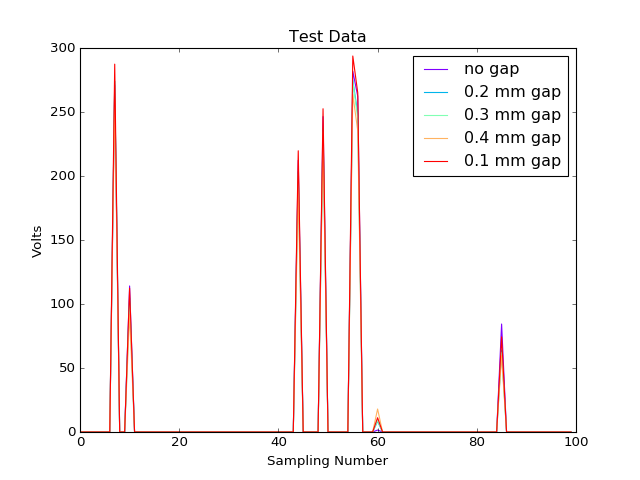

In [9]:
c=cm.rainbow(np.linspace(0,1,5))
labels=['no gap','0.2 mm gap','0.3 mm gap','0.4 mm gap','0.1 mm gap']
#%matplotlib notebook
plt.figure()
for c,signal,l in zip(c,EncodedTestData,labels):
    plt.plot(signal,color=c,label=l)

plt.xlabel('Sampling Number')
plt.ylabel('Volts')
plt.legend()
plt.title("Test Data")

In [18]:
DynamicWarp=[]
DynamicWarpTest=[]
[DynamicWarp.append(DynamicTimeWarping(encoded_signal[0],signal)) for signal in encoded_signal]
[DynamicWarpTest.append(DynamicTimeWarping(EncodedTestData[0],signal)) for signal in EncodedTestData]
gaps=[0,0.2,0.3,0.4,0.1]

Now, we will use the training data( DTW distance and gap-size), We will train ensemble of regression models on the training data. The model will be validated using the test data.

In [20]:
from sklearn import linear_model
#from sklearn import preprocessing

#DTWScaled=preprocessing.scale(DynamicWarp)

#DTWScaled=np.asarray(DTWScaled)
DynamicWarp=np.asarray(DynamicWarp)
gaps=np.asarray(gaps)
#lets create a regression object
regr= linear_model.LinearRegression(fit_intercept=True,normalize=True)
#fitting the linear regression

regr.fit(DynamicWarp.reshape(5,1),gaps.reshape(5,1))
print("The regression coefficients are as:[%.7f, %.7f]" % (regr.intercept_ ,  regr.coef_))
# The final prediction of the test data
DTWtest=np.asarray(DynamicWarpTest)
###
TrainingGaps=regr.predict(DynamicWarp.reshape(5,1))
PredictionGaps=regr.predict(DTWtest.reshape(5,1))

The regression coefficients are as:[0.1096717, 0.0000114]


We have fitted a linear regession model, now lets scale test data and use the regression model to predict 

<IPython.core.display.Javascript object>


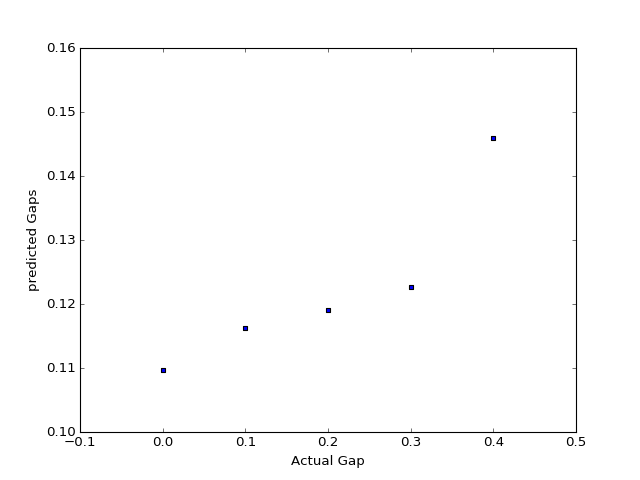

In [21]:
%matplotlib notebook
plt.figure()
plt.scatter(gaps,PredictionGaps, c='b', marker="s")
plt.xlabel('Actual Gap')
plt.ylabel('predicted Gaps')
plt.show()


Lets use Euclidean distance to measure dissimilarity of the damaged data from the baseline data.

In [23]:
dist=[]
for x in encoded_signal:
    dist.append(np.linalg.norm(encoded_signal[0]-x))

[0.0, 125.55881, 125.87907, 113.83719, 86.08197]